## ABC-XYZ Analysis

This notebook covers the coding approach for ABC-XYZ analysis concept with a small sample and synthetic data. A detailed article can be found at: 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")

#### Loaidng the data

In [2]:
data = pd.read_excel("ABC-XYZ-data.xlsx")

In [3]:
data.head()

,CustomerID,Timeperiod,Revenue,Quantity
0,111,2018-01-01,3000,150.0
1,111,2018-02-01,5000,250.0
2,111,2018-03-01,1500,75.0
3,111,2018-04-01,3000,150.0
4,111,2018-05-01,1450,72.5


In [4]:
data.columns

Index(['CustomerID', 'Timeperiod', 'Revenue', 'Quantity'], dtype='object')

**Data Description** - We have a monthly time series data having 4 fields CustomerID, Timeperiod, Revenue and Quantity 

Let's see how many month's data we have and how many customers we have

In [5]:
data['Timeperiod'].nunique()

24

In [6]:
data['CustomerID'].nunique()

28

So, we have information about just 28 unique customers and each having 24 months of data. And it is already given that there is no missing data for each customer, so each one has full 2 years worth of data 

#### Let's plot for each series

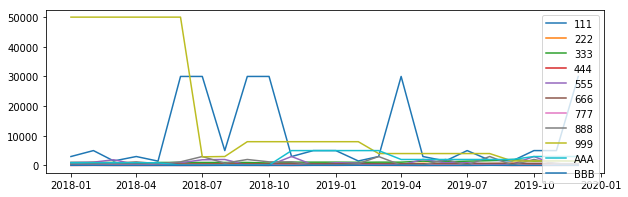

In [7]:
plt.figure(figsize=(10,3))
i = 0;
legend_values = []
for group, value in data.groupby(['CustomerID']):
    plt.plot(value['Timeperiod'], value['Revenue'])
    legend_values.append(group)
    i += 1
    if i>10:
        break
        
plt.legend(legend_values)   
plt.show()

We have quite a dynamic time-series data for each customer, now let's get down to business with the ABC-XYZ analysis. 

### ABC Analysis

In [8]:
def ABC_analysis(df):
    grouped_df = (
            df.loc[:, ['CustomerID','Revenue']]
            .groupby('CustomerID')
            .sum()         
        )

    grouped_df = grouped_df.sort_values(by=['Revenue'], ascending=False)
    
    ## Ranking by importance
    grouped_df["Rank"] = grouped_df['Revenue'].rank(ascending = False)
    grouped_df["Importance"] = ' '
    grouped_df = grouped_df.reset_index()

    ## Checking the Importance of the Customers and Categorising into class A,B,C and splitting based on 20-30-50
    grouped_df['Importance'][0: int(0.2 * grouped_df['Rank'].max())] = 'A'
    grouped_df['Importance'][int(0.2 * grouped_df['Rank'].max()) : int(0.5 * grouped_df['Rank'].max())] = 'B'
    grouped_df['Importance'][int(0.5 * grouped_df['Rank'].max()): ] = 'C'                  
    
    return grouped_df

In [9]:
ABC_groups = ABC_analysis(data)
ABC_groups.head()

,CustomerID,Revenue,Rank,Importance
0,XEEE,408000,1.0,A
1,999,383900,2.0,A
2,EEE,379000,3.0,A
3,111,239200,4.0,A
4,X999,134000,5.0,A


C    14
B     9
A     5
Name: Importance, dtype: int64

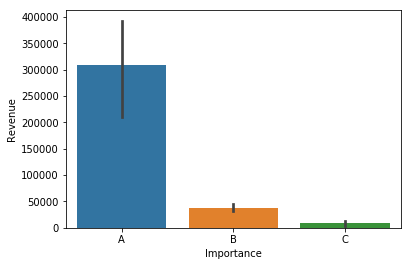

In [10]:
sns.barplot(x = 'Importance', y = 'Revenue',data = ABC_groups)
ABC_groups['Importance'].value_counts()

In [11]:
print("Now let's see importance contribution of each group")
ABC_groups.groupby('Importance')['Revenue'].sum() / ABC_groups['Revenue'].sum() * 100.

Now let's see importance contribution of each group


Importance
A    76.867245
B    17.189967
C     5.942787
Name: Revenue, dtype: float64

We clearly see that the 80-20 rule of Pareto is still valid with this data, where top 20% of the customers contribute almost 77% of the revenue share.

### XYZ Analysis

In this section we will do the XYZ Analysis and use MAPE as the forecastability metric

In [12]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split

In [31]:
def MAPE(y_orig, y_pred):
    diff = y_orig - y_pred
    MAPE = np.mean((abs(y_orig - y_pred)/y_orig)  * 100.)
    return MAPE

In [54]:
def XYZ_analysis(df):
    XYZ_list = []
    for group, value in df.groupby(['CustomerID']):
        grouped_df = (
                value.loc[:, ['Timeperiod','Quantity']].set_index('Timeperiod')      
        )

        # Using a simple Seasonal ARIMA model to highlight the idea, in the actual world, the model has to best fit the data
        train, test = train_test_split(grouped_df, train_size=18)

        model = pm.auto_arima(train, seasonal=True, m=4)

        forecasts = model.predict(test.shape[0])  # predict N steps into the future
        mape = MAPE(test.values.reshape(1,-1)[0], forecasts)
        XYZ_list.append([group, mape])
     
    XYZ_group = pd.DataFrame(XYZ_list, columns = ['CustomerID', 'MAPE'])
    XYZ_group = XYZ_group.sort_values(by=['MAPE'], ascending=True)
    
    ## Ranking by forecastability
    XYZ_group["Rank"] = XYZ_group['MAPE'].rank(ascending = True)
    XYZ_group["Forecastability"] = ' '
    
    ## Checking the Importance of the Customers and Categorising into class A,B,C and splitting based on 20-30-50
    XYZ_group['Forecastability'][0: int(0.2 * XYZ_group['Rank'].max())] = 'X'
    XYZ_group['Forecastability'][int(0.2 * XYZ_group['Rank'].max()) : int(0.5 * XYZ_group['Rank'].max())] = 'Y'
    XYZ_group['Forecastability'][int(0.5 * XYZ_group['Rank'].max()): ] = 'Z'
    
    return XYZ_group

In [55]:
XYZ_groups = XYZ_analysis(data)
XYZ_groups.head()

,CustomerID,MAPE,Rank,Forecastability
12,DDD,8.315260,1.0,X
1,222,17.640967,2.5,X
15,X222,17.640967,2.5,X
16,X333,20.324533,4.0,X
2,333,21.703583,5.0,X


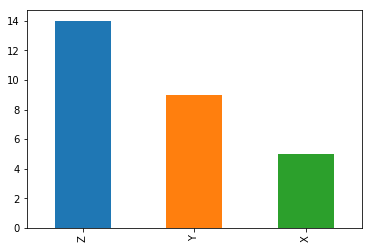

In [56]:
countXYZ = XYZ_groups['Forecastability'].value_counts()
countXYZ.plot.bar()

### ABC-XYZ Analysis

In this section we will merge both ABC and XYZ solutions together and see the final results

In [57]:
abc_xyz = pd.merge(XYZ_groups, ABC_groups, on='CustomerID', how='inner').iloc[:,[0,3,6]]

In [58]:
abc_xyz.head()

,CustomerID,Forecastability,Importance
0,DDD,X,C
1,222,X,C
2,X222,X,C
3,X333,X,B
4,333,X,B


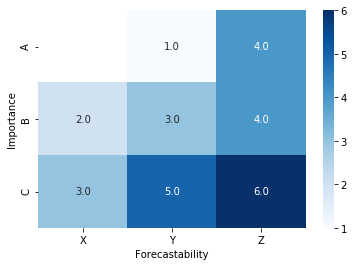

In [59]:
grouped_ABC_XYZ = abc_xyz.groupby(['Importance', 'Forecastability']).count()
result = grouped_ABC_XYZ.pivot_table(index = 'Importance', columns= 'Forecastability', values= 'CustomerID')
sns.heatmap(result, annot = True, fmt = '', cmap = 'Blues')

Finally, we would get an ABC-XYZ matrix which will be used by the business take to adopt new strategies and honestly considering that data we have, we see a lot of scope for improvment for an organization having a similar ABC-XYZ matrix! But the overall approach remains similar for any scenario!